In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from sklearn.model_selection import train_test_split

from scipy.optimize import leastsq

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
def info(df, head=True):
    print("Type: ", type(df))
    print("Shape: ", df.shape)
    print("Columns: ", df.columns)
    if head:
        display(df.head())
    else:
        display(df)

def corr_vis(df, features, meas='AVERAGEKWH_raw'):
    '''
    Displays a corrrelation chart for the  specified features in the edf
    '''
    ## Create a blank dataframe that calculates all the correlations to TOG
    vis = pd.DataFrame()
    vis['feature'] = features
    vis['spearman'] = [df[f].corr(df[meas], 'spearman') for f in features]
    #[print(str(features[f]) + ": " + str(spr['spearman'][f])) for f in range(len(features))]
    
    vis = vis.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    ax = sns.barplot(data=vis, y='feature', x='spearman', orient='h')
    
    ## Chart design
    ax.set(xlabel='correlation')
    ax.set(title='Correlation of all features to {meas}'.format(meas=meas)) 
    return vis

# Importing GeoDataFrames

California Counties and Boundarise sourced from https://data.ca.gov/dataset/ca-geographic-boundaries

In [3]:
base = "/datasets/team-red-residential-energy-consumption/datasets/team-red-residential-energy-consumption/Data/"

In [4]:
cleaned_monthly_with_zip_and_citis_fn = base + "cleaned_data/all-pge-with-nrel/transformed_pge-energy-consumption-with-nrel-solar_2013-2019_136968x35.shp"
zip_cities_monthly_pge_gdf = gpd.read_file(cleaned_monthly_with_zip_and_citis_fn)


In [5]:
rename_mapper ={
    'TOTALCUSTO': 'TOTALCUSTO_raw',
    'TOTALKWH_r': 'TOTALKWH_raw',
    'AVERAGEKWH': 'AVERAGEKWH_raw',
    'TOTALTHERM': 'TOTALTHERM_raw',
    'AVERAGETHE': 'AVERAGETHERM_raw',
    'Temperatur': 'Temperature_raw', 
    'Solar Zeni': 'Solar_Zenith_Angle_raw',
    'TOTALCUS_1': 'TOTALCUS_std', 
    'TOTALKWH_s': 'TOTALKWH_std', 
    'AVERAGEK_1': 'AVERAGEKWH_std', 
    'TOTALTHE_1': 'TOTALTHERM_std', 
    'AVERAGET_1': 'AVERAGETHERM_std',
    'Wind Spe_1': 'Wind_Speed_std', 
    'Temperat_1': 'Temperature_std',
    'Solar Ze_1': 'Solar_Zenith_Angle_std', 
}
zip_cities_monthly_pge_gdf = zip_cities_monthly_pge_gdf.rename(rename_mapper, axis=1)
zip_cities_monthly_pge_gdf['Solar_Zenith_Angle_raw'] = pd.to_numeric(zip_cities_monthly_pge_gdf['Solar_Zenith_Angle_raw'])
zip_cities_monthly_pge_gdf['Temperature_raw'] = pd.to_numeric(zip_cities_monthly_pge_gdf['Temperature_raw'])

In [6]:
info(zip_cities_monthly_pge_gdf)

Type:  <class 'geopandas.geodataframe.GeoDataFrame'>
Shape:  (136968, 36)
Columns:  Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')


,zip,city,state,latitude,longitude,timezone,dst,DATE,MONTH,YEAR,...,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std,geometry
0,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-01-01,1,2013,...,-0.590525,-0.46156,-0.348278,-1.198043,-1.373894,-0.709183,-1.894812,-2.255195,1.283431,POINT (-120.84510 39.17703)
1,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-02-01,2,2013,...,-0.590525,-0.46156,-0.348278,-0.621567,-0.990437,-0.041747,-1.837832,-1.881118,0.787489,POINT (-120.84510 39.17703)
2,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-03-01,3,2013,...,-0.590525,-0.46156,-0.348278,-0.341841,0.775179,-0.762886,-1.841878,-1.193114,0.089457,POINT (-120.84510 39.17703)
3,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-04-01,4,2013,...,-0.590525,-0.46156,-0.348278,0.639561,0.659686,0.529226,-1.828112,-0.713287,-0.643372,POINT (-120.84510 39.17703)
4,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-05-01,5,2013,...,0.278279,-0.46156,-0.348278,0.985208,0.972799,0.807632,-1.802339,-0.107015,-1.200288,POINT (-120.84510 39.17703)


### Sanity check geographic plots

#### California should look like California

#### PG&E dataset matches pg&e customers
PG&E service area reference: https://www.pge.com/mybusiness/customerservice/otherrequests/treetrimming/territory/

## Overlaying PG&E/NREL in Bay Area Only

Bay Area traditionally consists of [9 counties](https://wikitravel.org/en/Bay_Area_(California)).

<img src='https://wikitravel.org/upload/shared//thumb/b/bc/Bayarea_map.png/900px-Bayarea_map.png' style="width: 300px;">


We will define "Bay Area" as a box that encloses the following coordinates `(lat, long)`:

- South West corner: `(36.897966, -123.433313)`

- North East corner: `(38.593263, -121.381268)`

With these coordinates, we'll need to only consider data in the PG&E/NREL dataset that falls within this region.

In [7]:
approximate_bay_area_center_lat = 39.5769252
approximate_bay_area_center_long = -122.2833322

## for subsetting the ca counties
bay_area_south_west_lat  = 36.897966    ## vertical
bay_area_south_west_long = -123.433313 ## horizontal
bay_area_north_east_lat  = 38.593263    ## vertical --> closer to north pole => higher values
bay_area_north_east_long = -121.381268 ## horizontal --> west long < east long. west is more negative

## for plotting boundaries
bay_area_limit_south_west_lat  = 36.897966    ## vertical
bay_area_limit_south_west_long = -123.75 ## horizontal
bay_area_limit_north_east_lat  = 38.9    ## vertical --> closer to north pole => higher values
bay_area_limit_north_east_long = -121.2 ## horizontal --> west long < east long. west is more negative


### Filtering Bay Area Only Data


#### Boxing the CA Counties Data

#### Boxing the PG&E/NREL Data

In [8]:
zip_cities_monthly_pge_gdf.columns

Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')

In [9]:
## subset south west
bay_area_monthly_pge_nrel = zip_cities_monthly_pge_gdf[ (bay_area_south_west_long <= zip_cities_monthly_pge_gdf['longitude']) & (bay_area_south_west_lat <= zip_cities_monthly_pge_gdf['latitude']) ]

## subst north east
bay_area_monthly_pge_nrel = bay_area_monthly_pge_nrel[ (bay_area_monthly_pge_nrel['longitude'] <= bay_area_north_east_long) & (bay_area_monthly_pge_nrel['latitude'] <= bay_area_north_east_lat) ]


In [10]:
## Viewing how many measurements are the box
bay_area_monthly_pge_nrel.shape

(56683, 36)

In [11]:
bay_area_monthly_pge_nrel.columns
raw_cols = ["MONTH",'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw']
bay_area_monthly_pge_nrel_raw = bay_area_monthly_pge_nrel[raw_cols]
bay_area_monthly_pge_nrel_raw.head()

,MONTH,TOTALCUSTO_raw,TOTALKWH_raw,AVERAGEKWH_raw,TOTALTHERM_raw,AVERAGETHERM_raw,GHI_raw,DHI_raw,DNI_raw,Wind Speed,Temperature_raw,Solar_Zenith_Angle_raw
94,1,6727,3787580,563,0,0,116.13037634408602,29.18010752688172,222.91935483870967,2.123252688172044,7.276882,105.581747
95,2,6725,3086143,459,0,0,162.37946428571428,38.666666666666664,262.79017857142856,2.1078869047619047,9.022321,99.577827
96,3,6715,3091798,460,0,0,190.54569892473117,70.01209677419355,211.2741935483871,2.017607526881722,11.189516,91.109973
97,1,6166,0,0,562494,91,116.13037634408602,29.18010752688172,222.91935483870967,2.123252688172044,7.276882,105.581747
98,2,6172,0,0,388246,63,162.37946428571428,38.666666666666664,262.79017857142856,2.1078869047619047,9.022321,99.577827


In [12]:
measurment_cols = ["MONTH",'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std']

,feature,spearman
14,AVERAGEKWH_std,-0.773815
3,AVERAGEKWH_raw,-0.773815
2,TOTALKWH_raw,-0.773815
13,TOTALKWH_std,-0.773815
10,Temperature_raw,-0.186410
21,Temperature_std,-0.186410
17,GHI_std,-0.171452
19,DNI_std,-0.164958
8,DNI_raw,-0.162345
18,DHI_std,-0.128625


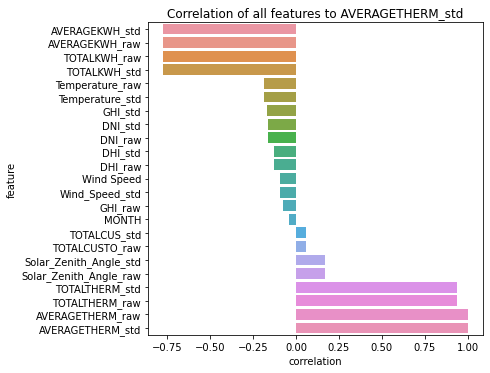

In [13]:
corr_vis(bay_area_monthly_pge_nrel, measurment_cols, meas='AVERAGETHERM_std')

In [14]:
X_cols = ['MONTH',
        # 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed'    , 'Temperature_raw', 'Solar_Zenith_Angle_raw'
        ]
bay_area_monthly_elec_pge_nrel = bay_area_monthly_pge_nrel[bay_area_monthly_pge_nrel['TOTALTHERM_raw']==0]
bay_area_monthly_elec_pge_nrel_clean = bay_area_monthly_elec_pge_nrel[bay_area_monthly_elec_pge_nrel['TOTALKWH_std'] < 10]
elec_X_train = bay_area_monthly_elec_pge_nrel_clean[X_cols]

## targetted_y can be changed to predict other values,
targetted_y = 'AVERAGEKWH_raw'
elec_Y_train = bay_area_monthly_elec_pge_nrel_clean[targetted_y]


In [15]:
elec_Y_train.mean()

457.2335485554034

In [16]:
bay_area_monthly_elec_pge_nrel_clean.describe()

,zip,latitude,longitude,MONTH,YEAR,DAY,TOTALCUSTO_raw,TOTALKWH_raw,AVERAGEKWH_raw,TOTALTHERM_raw,...,TOTALKWH_std,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std
count,30666.000000,30666.000000,30666.000000,30666.000000,30666.000000,30666.0,30666.000000,3.066600e+04,30666.000000,30666.0,...,30666.000000,30666.000000,3.066600e+04,3.066600e+04,30666.000000,30666.000000,30666.000000,30666.000000,30666.000000,30666.000000
mean,94737.878334,37.787116,-122.193570,6.479978,2015.786148,1.0,8087.939640,3.789959e+06,457.233549,0.0,...,0.739082,0.242276,-4.615598e-01,-3.482781e-01,-0.021728,0.032543,-0.054321,0.404610,-0.157148,-0.000645
std,459.910261,0.409973,0.356654,3.484611,2.021453,0.0,6908.315981,3.359593e+06,253.135856,0.0,...,1.135282,0.461059,1.110241e-16,5.551206e-17,0.970710,1.016678,0.942242,0.892265,0.673367,0.998189
min,94002.000000,36.922902,-123.229380,1.000000,2013.000000,1.0,0.000000,0.000000e+00,0.000000,0.0,...,-0.541630,-0.590525,-4.615598e-01,-3.482781e-01,-1.726467,-1.718965,-2.201362,-1.289944,-2.198615,-1.435575
25%,94512.000000,37.444879,-122.430100,3.000000,2014.000000,1.0,918.000000,5.522408e+05,350.000000,0.0,...,-0.355016,0.046962,-4.615598e-01,-3.482781e-01,-1.019955,-0.923597,-0.700843,-0.218190,-0.662881,-0.844779
50%,94613.000000,37.792678,-122.189940,6.000000,2016.000000,1.0,7409.500000,3.377306e+06,457.000000,0.0,...,0.599637,0.241851,-4.615598e-01,-3.482781e-01,-0.117098,0.039015,-0.066122,0.300822,-0.248118,0.082091
75%,95060.000000,38.031271,-121.950720,10.000000,2018.000000,1.0,13354.750000,5.984426e+06,575.000000,0.0,...,1.480642,0.456775,-4.615598e-01,-3.482781e-01,0.834873,0.818535,0.681497,0.892618,0.384143,1.130657
max,95823.000000,38.592155,-121.400220,12.000000,2019.000000,1.0,110585.000000,2.436159e+07,2401.000000,0.0,...,7.690700,3.782636,-4.615598e-01,-3.482781e-01,1.748295,4.262493,2.286722,4.351489,2.065529,1.424365


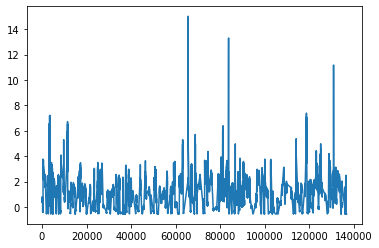

In [17]:
 plt.plot(bay_area_monthly_elec_pge_nrel['TOTALKWH_std'])
#keep this plot!! shows why we got rid of the data (and make prettier)
 #plt.plot(bay_area_monthly_elec_pge_nrel_clean['TOTALKWH_std']) #add this plot to it side by side to show
 

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TOTALKWH_std', ylabel='Density'>

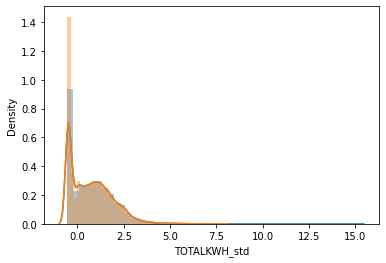

In [18]:
sns.distplot(bay_area_monthly_elec_pge_nrel['TOTALKWH_std'])
sns.distplot(bay_area_monthly_elec_pge_nrel_clean['TOTALKWH_std'])


In [19]:
## Trainv-validation split 
X_train, X_val, y_train, y_val = train_test_split(elec_X_train,elec_Y_train,test_size=0.2,
                                                  random_state=0)



### Simple Linear Regression

$$ \hat{\vec{y}} = \hat{\vec\beta}*\vec{x}$$

Coefficients in $ \hat{\vec\beta}$  are simply scalars that are fit to the best-fit line. That is, simply solving least squares

$$ \hat{\vec\beta} = (X^TX)^{-1}X^TY$$


In [20]:
lm = LinearRegression() #linear regression
lm.fit(X_train, y_train)

## apply model to training data
lm_train_pred = lm.predict(X_train)
lm_train_mse = mean_squared_error(y_true=y_train, y_pred=lm_train_pred)

## apply model to test data
lm_test_pred = lm.predict(X_val)
lm_test_mse = mean_squared_error(y_true=y_val, y_pred=lm_test_pred)
print("Training MSE", lm_train_mse)
print("Testing MSE", lm_test_mse)

Training MSE 63727.888697826565
Testing MSE 65174.33659987724


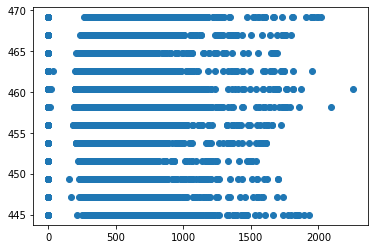

In [21]:
plt.scatter(y_train, lm_train_pred)

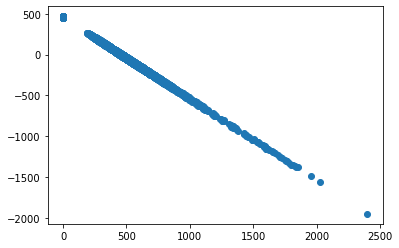

In [22]:
plt.scatter(y_val, lm_test_pred-y_val)

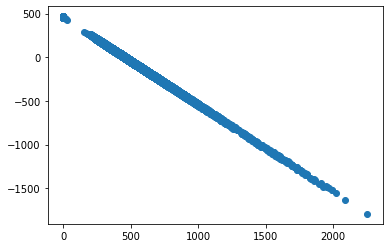

In [23]:
plt.scatter(y_train, lm_train_pred-y_train)

In [24]:
svr_regr = svm.SVR() #vector regression
svr_regr.fit(X_train, y_train)

SVR()

In [25]:
## apply model to training data
svr_train_pred = svr_regr.predict(X_train)
svr_train_mse = mean_squared_error(y_true=y_train, y_pred=svr_train_pred)

## apply model to test data
svr_test_pred = svr_regr.predict(X_val)
svr_test_mse = mean_squared_error(y_true=y_val, y_pred=svr_test_pred)
print("Training MSE", svr_train_mse)
print("Testing MSE", svr_test_mse)

Training MSE 62155.81959561899
Testing MSE 63700.430481977615


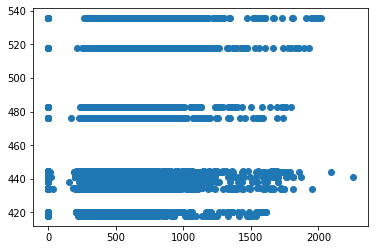

In [26]:
plt.scatter(y_train, svr_train_pred)

### Decision Tree Regression Model

In [27]:
X_train.head()

,MONTH
73651,8
105904,3
12682,5
50030,2
14991,3


In [28]:
dtree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

In [29]:
## apply model to training data
dtree_train_pred = dtree.predict(X_train)
dtree_train_mse = mean_squared_error(y_true=y_train, y_pred=dtree_train_pred)

## apply model to test data
dtree_test_pred = dtree.predict(X_val)
dtree_test_mse = mean_squared_error(y_true=y_val, y_pred=dtree_test_pred)
print("Training MSE", dtree_train_mse)
print("Testing MSE", dtree_test_mse)

Training MSE 62635.12201918334
Testing MSE 64235.58537766066


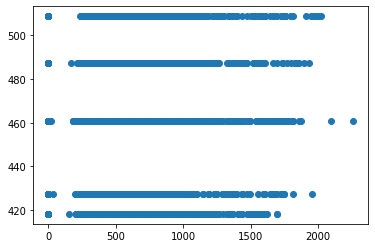

In [30]:
plt.scatter(y_train, dtree_train_pred)

In [31]:
### Standardized SVR

In [32]:
pipe = Pipeline([('scaler', StandardScaler()), ('svr', svm.SVR())])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

In [33]:
pipe.score(X_val, y_val)

0.02345187481684763

In [34]:
pipe.score(X_train, y_train)

0.025568943863417348

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2f0e727-e6a4-4b2a-b180-a91c3a609ecf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>